In [3]:
from torch_geometric.data import DataLoader
from data import Dataset
from model import Encoder, GRACE

In [2]:
space = 'nasbench201'
dataset = Dataset(space=space, root='~/datasets')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

try to create the NAS-Bench-201 api from /home/jingkun/datasets/NAS-Bench-201-v1_1-096897.pth


In [3]:
encoder = Encoder(len(dataset.available_ops), 300, 256, torch.nn.PReLU(), k=2, skip=False)
model = GRACE(encoder, 256, 32, 0.4)
for i, batch in enumerate(dataloader):
    print(len(batch))
    x, g = model(batch.x, batch.edge_index, batch.ptr)
    print(x.size())
    print(g.size())
    loss, node_loss, graph_loss = model.loss(x, x, g, g, batch.ptr)
    print(loss, node_loss, graph_loss)
    break

NameError: name 'torch' is not defined

# 降维

In [36]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

## PCA

<class 'numpy.ndarray'>


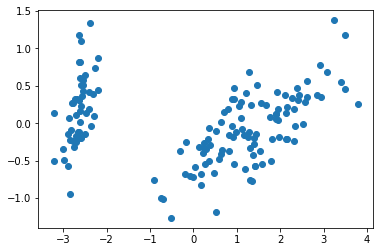

In [41]:
data = load_iris()
X = data.data

sklearn_pca = PCA(n_components=2)
data_2d = sklearn_pca.fit_transform(X)
plt.figure()
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.show()

# 图嵌入可视化

In [1]:
import os
import numpy as np
import torch
from itertools import chain
from torch_geometric.data import InMemoryDataset, Data, Batch

In [2]:
# nasbench101
root = '/home/jingkun/datasets'
from nasbench import api as NASBench101API
data_path = os.path.join(root, 'nasbench_full.tfrecord')
nasbench = NASBench101API.NASBench(data_path)
available_ops = ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output']

2022-01-05 16:25:09.417715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 153 seconds


In [5]:
# nasbench201
root = '/home/jingkun/datasets'
from nas_201_api import NASBench201API
data_path = os.path.join(root, 'NAS-Bench-201-v1_1-096897.pth')
nasbench = NASBench201API(data_path, verbose=False)
available_ops = ['input', 'none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3', 'output']

In [3]:
def nasbench201_to_nasbench101(arch_list):
    num_ops = sum(range(1, 1 + len(arch_list))) + 2
    adj = np.zeros((num_ops, num_ops), dtype=np.uint8)
    ops = ['input', 'output']
    node_lists = [[0]]
    for node_201 in arch_list:
        node_list = []
        for node in node_201:
            node_idx = len(ops) - 1
            adj[node_lists[node[1]], node_idx] = 1
            ops.insert(-1, node[0])
            node_list.append(node_idx)
        node_lists.append(node_list)
    adj[-(1+len(arch_list)):-1, -1] = 1
    arch = {'adj': adj,
            'ops': ops,}
    return arch


def arch2Data(arch):
    x = torch.tensor([available_ops.index(x) for x in arch['ops']], dtype=torch.long)
    if 'acc' in arch.keys():
        y = torch.ones_like(x) * arch['acc']
    else:
        y = None
    forward_edges = [[(i, j) for j, x in enumerate(xs) if x > 0] for i, xs in enumerate(arch['adj'])]
    forward_edges = np.array(list(chain(*forward_edges)))
    backward_edges = forward_edges[::-1, ::-1]
    edges = np.concatenate([forward_edges, backward_edges])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    data = Data(x=x, y=y, edge_index=edge_index)
    return data

# def arch2Data(arch):
#     x = torch.tensor([available_ops.index(x) for x in arch['ops']], dtype=torch.long)
#     if 'acc' in arch.keys():
#         y = torch.ones_like(x) * arch['acc']
#     else:
#         y = None
#     forward_edges = [[(i, j) for j, x in enumerate(xs) if x > 0] for i, xs in enumerate(arch['adj'])]
#     forward_edges = np.array(list(chain(*forward_edges)))
#     backward_edges = forward_edges[::-1, ::-1]
#     edges = np.concatenate([forward_edges, backward_edges])
#     edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
#     data = Data(x=x, y=y, edge_index=edge_index)
#     return data

In [45]:
arch1 = {'adj': np.array([[0, 1, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output'],}
arch2 = {'adj': np.array([[0, 1, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output'],}
arch3 = {'adj': np.array([[0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 1, 0, 1, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output'],}
arch4 = {'adj': np.array([[0, 1, 0, 0, 0, 0, 0],
                          [0, 0, 1, 1, 0, 1, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output'],}
arch5 = {'adj': np.array([[0, 1, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output'],}
arch6 = {'adj': np.array([[0, 1, 1, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output'],}
arch7 = {'adj': np.array([[0, 1, 0, 0, 1, 0, 0],
                          [0, 0, 1, 0, 0, 1, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output'],}
arch8 = {'adj': np.array([[0, 1, 0, 0, 1, 0, 0],
                          [0, 0, 1, 0, 0, 1, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'output'],}
arch9 = {'adj': np.array([[0, 1, 1, 0, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1, 1, 1],
                          [0, 0, 0, 0, 0, 1, 0],
                          [0, 0, 0, 0, 0, 0, 1],
                          [0, 0, 0, 0, 0, 0, 0]]),
         'ops': ['input', 'maxpool3x3', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output'],}
fixed = nasbench.fixed_statistics[list(nasbench.hash_iterator())[100000]]
arch10 = {'adj': fixed['module_adjacency'], 'ops': fixed['module_operations']}
archs = [(arch1,), (arch2,), (arch3,), (arch4,), (arch5,), (arch6,), (arch7,), (arch8,), (arch9,), (arch10,)]

print(archs)
data_list = []
for arch in archs:
    data_list.append(arch2Data(arch[0]))
batch = Batch.from_data_list(data_list)
print(batch)

[({'adj': array([[0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]]), 'ops': ['input', 'conv1x1-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']},), ({'adj': array([[0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]]), 'ops': ['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'output']},), ({'adj': array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]]), 'ops': ['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3

In [37]:
arch_1  = [(('avg_pool_3x3', 0),), (('nor_conv_1x1', 0), ('skip_connect', 1)), (('nor_conv_1x1', 0), ('skip_connect', 1), ('skip_connect', 2))]
arch_1_ = [(('avg_pool_3x3', 0),), (('nor_conv_1x1', 0), ('nor_conv_3x3', 1)), (('nor_conv_1x1', 0), ('skip_connect', 1), ('skip_connect', 2))]
arch_2  = [(('nor_conv_1x1', 0),), (('nor_conv_3x3', 0), ('skip_connect', 1)), (('skip_connect', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
arch_2_ = [(('nor_conv_1x1', 0),), (('nor_conv_3x3', 0), ('nor_conv_3x3', 1)), (('skip_connect', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
arch_3  = [(('nor_conv_3x3', 0),), (('nor_conv_3x3', 0), ('skip_connect', 1)), (('avg_pool_3x3', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
arch_3_ = [(('nor_conv_3x3', 0),), (('nor_conv_3x3', 0), ('nor_conv_3x3', 1)), (('avg_pool_3x3', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))]
archs = [(arch_1,), (arch_1_,), (arch_2,), (arch_2_,), (arch_3,), (arch_3_,), ]

arch_1  = nasbench201_to_nasbench101(arch_1)
arch_1_ = nasbench201_to_nasbench101(arch_1_)
arch_2  = nasbench201_to_nasbench101(arch_2)
arch_2_ = nasbench201_to_nasbench101(arch_2_)

print(archs)
data_list = []
for arch in archs:
    a = nasbench201_to_nasbench101(arch[0])
    data_list.append(arch2Data(a))
batch = Batch.from_data_list(data_list)
print(batch)

[([(('avg_pool_3x3', 0),), (('nor_conv_1x1', 0), ('skip_connect', 1)), (('nor_conv_1x1', 0), ('skip_connect', 1), ('skip_connect', 2))],), ([(('avg_pool_3x3', 0),), (('nor_conv_1x1', 0), ('nor_conv_3x3', 1)), (('nor_conv_1x1', 0), ('skip_connect', 1), ('skip_connect', 2))],), ([(('nor_conv_1x1', 0),), (('nor_conv_3x3', 0), ('skip_connect', 1)), (('skip_connect', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))],), ([(('nor_conv_1x1', 0),), (('nor_conv_3x3', 0), ('nor_conv_3x3', 1)), (('skip_connect', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))],), ([(('nor_conv_3x3', 0),), (('nor_conv_3x3', 0), ('skip_connect', 1)), (('avg_pool_3x3', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))],), ([(('nor_conv_3x3', 0),), (('nor_conv_3x3', 0), ('nor_conv_3x3', 1)), (('avg_pool_3x3', 0), ('skip_connect', 1), ('avg_pool_3x3', 2))],)]


ValueError: 'avg_pool_3x3' is not in list

In [46]:
from utils import get_base_model, get_activation
from model import PairWiseLearning_BARLOW_TWINS, PairWiseLearning_MVGRL, Predictor, MAELearning
#encoder = Encoder(len(available_ops), 32, 128, get_activation('prelu'), base_model=get_base_model('GATConv'), k=3, skip=True, use_bn=True)
encoder = MAELearning(len(available_ops), 16, 32, get_activation('prelu'), get_base_model('GATConv'), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, '64')
#encoder.load_state_dict(torch.load(os.path.join('finetune101_rep', 'finetune_encoder_449.pt')), False)
#encoder.load_state_dict(torch.load(os.path.join('pretrain101_aug_mask_1', 'model_449.pt')))
#encoder.load_state_dict(torch.load(os.path.join('pretrain101_aug_diff_1', 'model_449.pt')))
#encoder.load_state_dict(torch.load(os.path.join('pretrain101_aug_mask_diff_1', 'model_449.pt')))
#encoder.load_state_dict(torch.load(os.path.join('finetune101_rep_mask_1', 'finetune_encoder_449.pt')), False)
#encoder.load_state_dict(torch.load(os.path.join('finetune101_rep_diff_1', 'finetune_encoder_449.pt')), False)
#encoder.load_state_dict(torch.load(os.path.join('finetune101_rep_mask_diff_1', 'finetune_encoder_449.pt')), False)
encoder.load_state_dict(torch.load(os.path.join('pretrain101', 'best_model_15712.pt')))
#print(encoder)

<All keys matched successfully>

In [47]:
encoder.eval()
x          = batch.x
edge_index = batch.edge_index
ptr        = batch.ptr
with torch.no_grad():
    z, g = encoder(x, edge_index, ptr, x, edge_index, ptr)
g = g.detach().numpy()
print(g.shape)

(10, 32)


[[ 0.00168542  0.07303245]
 [ 0.06506784 -0.02570245]
 [ 0.81249714  0.0597867 ]
 [ 1.1712697   0.304913  ]
 [-0.33354652 -0.3287491 ]
 [-0.30415145 -0.34172133]
 [-0.12970825 -0.16036227]
 [-0.29662374 -0.4294592 ]
 [ 0.00168544  0.07303237]
 [-0.98817444  0.77522933]]


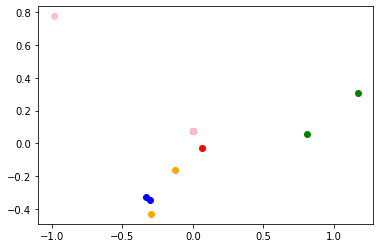

In [50]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
sklearn_pca = PCA(n_components=2)
data_2d = sklearn_pca.fit_transform(g)
print(data_2d)
plt.figure()
colors = ['red','green','blue','orange','pink', 'black']
for i in range(data_2d.shape[0]//2-1):
    plt.scatter(data_2d[2*i:2*(i+1), 0], data_2d[2*i:2*(i+1), 1], c=colors[i])
plt.scatter(data_2d[8:9, 0], data_2d[8:9, 1], c=colors[-1])
plt.scatter(data_2d[9:10, 0], data_2d[9:10, 1])
plt.show()